Импортируем необходимые библиотеки

In [ ]:
#import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch

import json
import os
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
from google.colab import drive
MODE = "MOUNT"
if MODE == "MOUNT":
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

Загружаем набор картинок

In [ ]:
#!unzip -q "/content/drive/MyDrive/VKR/MarkedImages.zip" -d "MarkedImages"
#download markup
!unzip -q "/content/drive/MyDrive/Saggital/MarkedImagesNew.zip" -d "/content/MarkedImagesNew"

!ls

binary_mask  drive  MarkedImagesNew  sample_data


### Меняем формат

In [ ]:
for dpath, dnames, fnames in os.walk('/content/MarkedImagesNew'):
    for f in fnames:
        os.chdir(dpath)
        if f.endswith(".PNG"):
            os.rename(f, f.replace('PNG','bmp'))

In [ ]:
RESCALE_SIZE = 256

### Визуализиурем несколько картинок

In [ ]:
file_dir = Path('/content/MarkedImagesNew')

files = sorted(list(file_dir.rglob('*.bmp')))

In [ ]:
# method for image(Tensor) plotting
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    #inp = inp.transpose((1, 2, 0))
    #inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

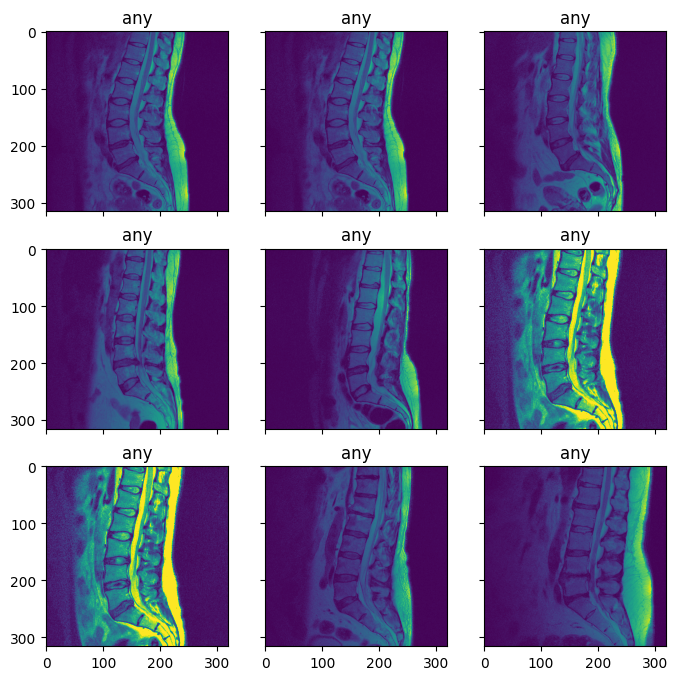

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,90))
    im_val = Image.open(files[random_characters])
    im_val = np.asarray(im_val)
    imshow(im_val, \
          title="any",plt_ax=fig_x)

### Раметка и маски

 Загрузим разметку *.json* , выберем то что нужно нам, создадим общий файл

In [ ]:
f = open('/content/drive/MyDrive/Saggital/sag_151_180.json')

data = json.load(f)

f.close()
data_first= dict(list(data['_via_img_metadata'].items())[150:181])
f = open('/content/drive/MyDrive/Saggital/sag_200_230.json')

data2 = json.load(f)

f.close()
data_second= dict(list(data2['_via_img_metadata'].items())[200:231])


f= open('/content/drive/MyDrive/Saggital/sag_1395_1437.json')

data3 = json.load(f)

data_third = dict(list(data3['_via_img_metadata'].items())[1395:1438])

In [ ]:
data_third.keys()

dict_keys(['01395.PNG64191', '01396.PNG65137', '01397.PNG64782', '01398.PNG65933', '01399.PNG66781', '01400.PNG63489', '01401.PNG63276', '01402.PNG65366', '01403.PNG64998', '01404.PNG63605', '01405.PNG63535', '01406.PNG63958', '01407.PNG61060', '01408.PNG63941', '01409.PNG62408', '01410.PNG65142', '01411.PNG65782', '01412.PNG65035', '01413.PNG65551', '01414.PNG66068', '01415.PNG64610', '01416.PNG65544', '01417.PNG66412', '01418.PNG67297', '01419.PNG67031', '01420.PNG65715', '01421.PNG65339', '01422.PNG65816', '01423.PNG66302', '01424.PNG64275', '01425.PNG64483', '01426.PNG64853', '01427.PNG65318', '01428.PNG65382', '01429.PNG65498', '01430.PNG65035', '01431.PNG64939', '01432.PNG61606', '01433.PNG62425', '01434.PNG62094', '01435.PNG62547', '01436.PNG61669', '01437.PNG62150'])

In [ ]:
del data_third['01400.PNG63489']
del data_third['01401.PNG63276']
del data_third['01414.PNG66068']
del data_third['01423.PNG66302']
del data_third['01435.PNG62547']

In [ ]:
data_third.keys()

dict_keys(['01395.PNG64191', '01396.PNG65137', '01397.PNG64782', '01398.PNG65933', '01399.PNG66781', '01402.PNG65366', '01403.PNG64998', '01404.PNG63605', '01405.PNG63535', '01406.PNG63958', '01407.PNG61060', '01408.PNG63941', '01409.PNG62408', '01410.PNG65142', '01411.PNG65782', '01412.PNG65035', '01413.PNG65551', '01415.PNG64610', '01416.PNG65544', '01417.PNG66412', '01418.PNG67297', '01419.PNG67031', '01420.PNG65715', '01421.PNG65339', '01422.PNG65816', '01424.PNG64275', '01425.PNG64483', '01426.PNG64853', '01427.PNG65318', '01428.PNG65382', '01429.PNG65498', '01430.PNG65035', '01431.PNG64939', '01432.PNG61606', '01433.PNG62425', '01434.PNG62094', '01436.PNG61669', '01437.PNG62150'])

Некоторые картинки были без разметки, поэтому их нужео удалить

In [ ]:
mark = dict(data_first)
mark.update(data_second)
mark.update(data_third)

In [ ]:
out_file = open("/content/drive/MyDrive/Saggital/annotation.json", "w")

json.dump(mark, out_file)

out_file.close()

Теперь есть словарик с разметкой: **annotation.json**(Картинка 150)
Сгенирируем бинарные маски


In [ ]:
os.chdir('/content')
!pwd
!mkdir binary_mask
os.listdir(r'/content')

/content
mkdir: cannot create directory ‘binary_mask’: File exists


['.config', 'binary_mask', 'drive', 'sample_data']

In [ ]:
!pwd

/content


In [ ]:
!mkdir binary_mask

mkdir: cannot create directory ‘binary_mask’: File exists


In [ ]:
os.listdir(r'/content')

['.config', 'MarkedImagesNew', 'binary_mask', 'drive', 'sample_data']

Следующий скрипт генерирует бинырные маски для разметки annotation

In [ ]:
with open("/content/drive/MyDrive/Saggital/annotation.json", "r") as read_file:
    data = json.load(read_file)

all_file_names=list(data.keys())

Files_in_directory = []
for root, dirs, files in os.walk("/content/MarkedImagesNew"):
    for filename in files:
        Files_in_directory.append(filename)

for j in range(len(all_file_names)):
    image_name=data[all_file_names[j]]['filename']

    if image_name in Files_in_directory:
         img = np.asarray(Image.open('/content/MarkedImagesNew/'+image_name))
    else:
        continue

    # создаем пустую маску
    mask = np.zeros((img.shape[0],img.shape[1]))
    mask_result = np.zeros((img.shape[0], img.shape[1]))

    for k in range(len(data[all_file_names[j]]['regions'])):
        if data[all_file_names[j]]['regions'] != {}:
            try:
                shape1_x=data[all_file_names[j]]['regions']['0']['shape_attributes']['all_points_x']
                shape1_y=data[all_file_names[j]]['regions']['0']['shape_attributes']['all_points_y']
            except :
                shape1_x=data[all_file_names[j]]['regions'][k]['shape_attributes']['all_points_x']
                shape1_y=data[all_file_names[j]]['regions'][k]['shape_attributes']['all_points_y']

            ab=np.stack((shape1_x, shape1_y), axis=1)
            mask = cv2.drawContours(mask, [ab], -1, RESCALE_SIZE, -1)

    # сохраняем маску в виде изображения
    cv2.imwrite('/content/binary_mask/%05.0f' % j +'.JPG',mask.astype(np.uint64))

    # добавляем текущую маску к общей маске для всех предыдущих изображений
    if j > 0:
        mask_prev = np.asarray(Image.open('/content/binary_mask/%05.0f' % (j-1) +'.JPG'))
        if mask_prev.shape != mask.shape:
            mask_prev = cv2.resize(mask_prev, (img.shape[1],img.shape[0]))
        if mask_prev.shape != img.shape[:2]:
         mask_prev = cv2.resize(mask_prev, (img.shape[1],img.shape[0]))
        if mask.shape != img.shape[:2]:
         mask = cv2.resize(mask, (img.shape[1],img.shape[0]))
         mask_result = cv2.bitwise_or(cv2.resize(mask_prev, (mask.shape[1], mask.shape[0])), mask)

In [ ]:
image_name

'01437.PNG'

Dataloader`s

In [ ]:
masks = []
images = []
from skimage.io import imread
import os
def checkPath(list_path,images,masks):
    i=0
    for path in list_path:
        i+=1
        for path, dirs, files in os.walk(path):
            files = sorted(files)
            if i==1:
              for o in files:
                images.append(imread(os.path.join(path,o)))
              continue;
            else:
              for o in files:
                masks.append(imread(os.path.join(path,o)))
              continue;
    return images,masks

images,masks = checkPath(['/content/MarkedImagesNew','/content/binary_mask'],images,masks)

Всего картинок:

In [ ]:
!mkdir '/content/drive/MyDrive/Saggital/Masks'



In [ ]:


source = '/content/binary_mask'
destination = '/content/drive/MyDrive/Saggital/Masks'

import shutil


# gather all files
allfiles = os.listdir(source)

# iterate on all files to move them to destination folder
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    shutil.move(src_path, dst_path)

In [ ]:
with open('/content/drive/MyDrive/Saggital/Masks') as f:
  for i in range(len(masks)):
    f.dump(masks)

In [ ]:
len(images)
len(masks)

100

In [ ]:
from skimage.transform import resize
size = (RESCALE_SIZE, RESCALE_SIZE)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 100 images


In [ ]:
len(Y)

100

In [ ]:
X = np.stack((X,)*3, axis=3)

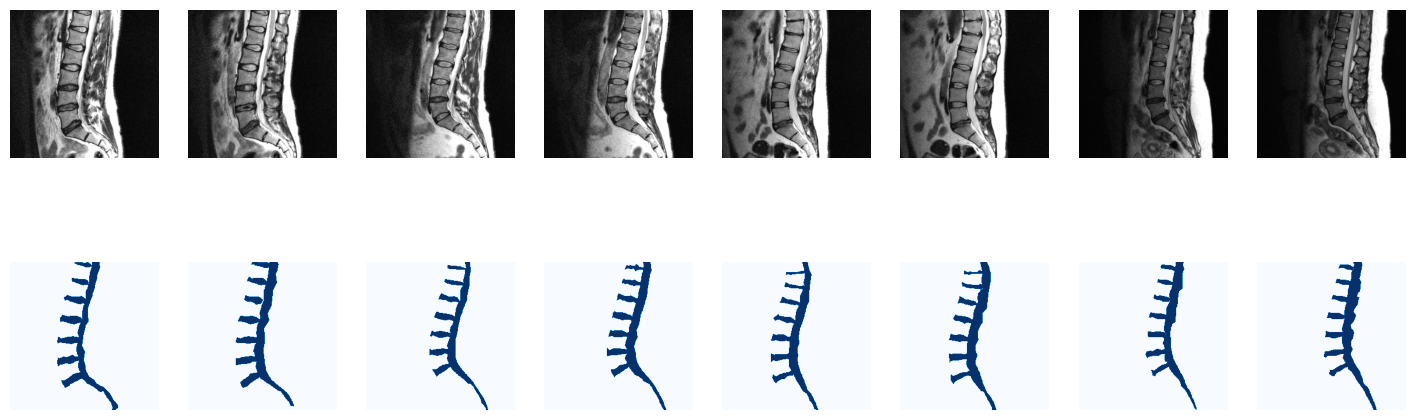

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.axis("off")
    plt.imshow(X[i],cmap='cividis')

    plt.subplot(2, 8, i+9)
    plt.axis("off")
    plt.imshow(Y[i],cmap='Blues')
plt.show();

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [60, 80])

In [ ]:
print(len(tr),len(val),len(ts))

60 20 20


# Data batching

In [ ]:
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size,  shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size,  shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from tqdm.notebook import tqdm

from matplotlib import rcParams

# Metrics

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    return thresholded

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            Y_pred = model(X_batch)
            #Y_pred = (Y_pred >= 0.5)
            Y_pred = (torch.sigmoid(Y_pred) >= 0.5)
            scores += metric(Y_pred, Y_label).mean().item()
    return scores/len(data)

# Model Architecture`s

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # pool, unpool
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=(2, 2), stride=2)

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #self.pool0 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        #self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        #self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        #self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        #self.upsample0 =  # 16 -> 32
        self.dec_conv0 = nn.Sequential(

            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        #self.upsample1 =  # 32 -> 64
        self.dec_conv1 = nn.Sequential(

            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        #self.upsample2 =   # 64 -> 128
        self.dec_conv2 = nn.Sequential(

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        #self.upsample3 =   # 128 -> 256
        self.dec_conv3 = nn.Sequential(

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1))
        )

    def forward(self, x):
        # encoder
        enc_conv0_output = self.enc_conv0(x)
        e0, indices1 = self.pool(enc_conv0_output)

        enc_conv1_output = self.enc_conv1(e0)
        e1, indices2 = self.pool(enc_conv1_output)

        enc_conv2_output = self.enc_conv2(e1)
        e2, indices3 = self.pool(self.enc_conv2(e1))

        enc_conv3_output = self.enc_conv3(e2)
        e3, indices4 = self.pool(enc_conv3_output)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.unpool(b, indices4), enc_conv3_output), dim=1))
        d1 = self.dec_conv1(torch.cat((self.unpool(d0, indices3), enc_conv2_output), dim=1))
        d2 = self.dec_conv2(torch.cat((self.unpool(d1, indices2), enc_conv1_output), dim=1))
        d3 = self.dec_conv3(torch.cat((self.unpool(d2, indices1), enc_conv0_output), dim=1))  # no activation
        return d3

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.

In [ ]:
class UNet3(nn.Module):
    def __init__(self):
        super().__init__()


        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3,32,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.Conv2d(64,64,3,2,1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64,64,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128)
        )
        self.pool1 =  nn.Conv2d(128,128,3,2,1)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128,128,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256)
        )
        self.pool2 = nn.Conv2d(256,256,3,2,1)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256,256,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256,512,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(512)
        )
        self.pool3 = nn.Conv2d(512,512,3,2,1)  # 32 -> 16

        # bottleneck
        self.bottle_neck = nn.Sequential(
            nn.Conv2d(512,1024,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024,512,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(512)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512,512,3,2,1) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512*2,256,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256,256,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256)
        )
        self.upsample1 =  nn.ConvTranspose2d(256,256,3,2,1) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256*2,128,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128)
        )
        self.upsample2 =   nn.ConvTranspose2d(128,128,3,2,1) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128*2,128,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,64,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64)
        )
        self.upsample3 =   nn.ConvTranspose2d(64,64,3,2,1) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64*2,32,3,1,1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,1,3,1,1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):

        pre_e0 = self.enc_conv0(x)
        e0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3 = self.pool3(pre_e3)


        bottle_neck = self.bottle_neck(e3)


        d0 = self.dec_conv0(torch.cat([self.upsample0(bottle_neck, output_size=pre_e3.size()), pre_e3], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0, output_size=pre_e2.size()), pre_e2], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1, output_size=pre_e1.size()), pre_e1], 1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2, output_size=pre_e0.size()), pre_e0], 1))

        return d3

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    X_val, Y_val = next(iter(data_val))
    train_loss = []
    val_loss = []
    iou_score = []
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in tqdm(data_tr):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
            avg_loss += loss / len(data_tr)

        train_loss.append(avg_loss.item())
        toc = time()
        print('loss train: %f' % avg_loss)

        if scheduler is not None:
            scheduler.step(avg_loss)
            #print(opt.param_groups[0]['lr'])

        # show intermediate results
        model.eval()  # testing mode
        X_val, Y_val = X_val.to(device), Y_val.to(device)
        Y_hat = model(X_val)
        loss = loss_fn(Y_val, Y_hat)
        Y_hat = torch.sigmoid(Y_hat)
        val_loss.append(loss.item()/len(data_val))

        iou = score_model(model, iou_pytorch, data_val)
        iou_score.append(iou)

        print('loss valid: %f' % val_loss[-1])

        # сохраняем веса лучшей модели
        if val_loss[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_loss[-1]))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = val_loss[-1]

        Y_hat, X_val, Y_val = Y_hat.detach().to('cpu'), X_val.to('cpu'), Y_val.to('cpu')

        # Visualize tools
        clear_output(wait=True)
        for k in range(4):
            plt.subplot(2, 4, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 4, k+5)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    # загружаем модель с лучшими весами
    model.load_state_dict(torch.load('model.pt'))
    print('loading best model state')

    return val_loss, train_loss, iou_score

In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    y_real.to(device)
    num = 2 * (y_real * y_pred).mean((1, 2, 3))
    den = (y_real + y_pred).mean((1, 2, 3))
    res = (1 - num/den)
    return torch.mean(res)

# Training

In [ ]:
from torch.utils.data import DataLoader
batch_size = 4
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size,  shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size,  shuffle=True)

In [ ]:
unet_model = UNet().to(device)

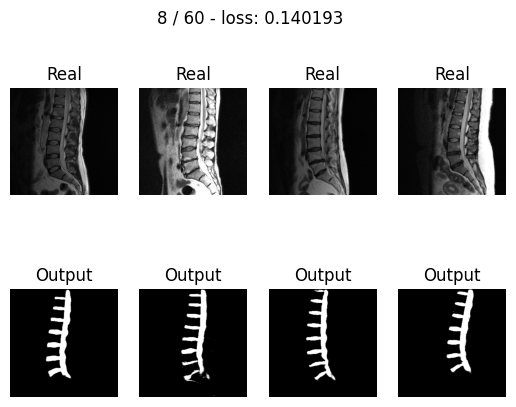

* Epoch 9/60


  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
tuples = train(unet_model, torch.optim.Adadelta(unet_model.parameters()), dice_loss, 60, data_tr, data_val)

# Inference

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.6950000166893006

Важно!
В **train** выходные параметры в такой последовательности: $val\_loss, train\_loss, iou\_score$

В **train_**  в такой: $losses\_train,losses\_val,score\_train,score\_val$

Пожалуйста, обрати на это внимание при постоении графиков.

In [ ]:
def plot_results(rslts, ttl=''):
    plt.figure(figsize=(15, 15))
    fig,axs = plt.subplots(2,1)
    # это код для распоковки тензора [ x.item() for x in rslts[0] ]
    axs[0].plot(rslts[0], label="vall_loss")
    axs[1].plot(rslts[1], label="train_loss")
    #plt.plot(rslts[2], label="train_score")
    #plt.plot(rslts[3], label="val_score")

    axs[0].grid(True)
    axs[1].grid(True)
    axs[0].legend(loc='best')
    axs[0].set_xlabel("epochs")
    axs[0].set_ylabel("loss")
    plt.title(ttl)
    axs[1].legend(loc='best')
    axs[1].set_xlabel("epochs")
    axs[1].set_ylabel("loss")
    fig.tight_layout()
    plt.show()
plot_results(tuples)

NameError: ignored

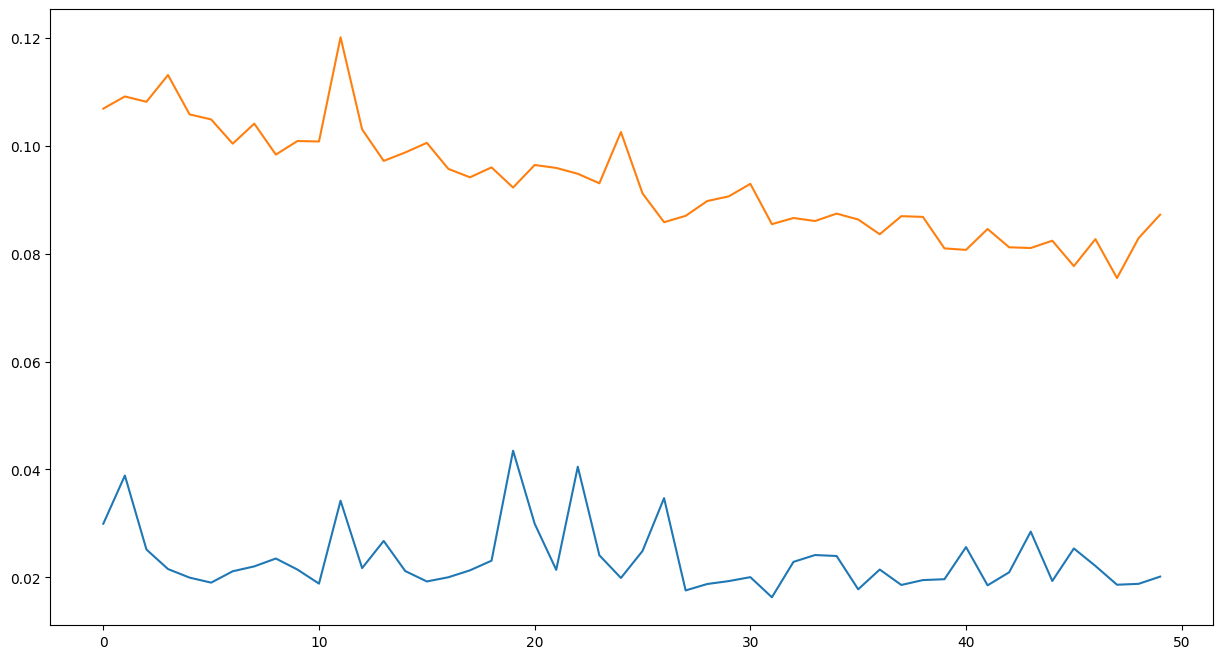

In [ ]:
def plot_resultss(rslts, ttl=''):
    plt.figure(figsize=(15, 8))
    # это код для распоковки тензора [ x.item() for x in rslts[0] ]
    plt.plot(rslts[0], label="vall_loss")
    plt.plot(rslts[1], label="train_loss")
    #plt.plot(rslts[2], label="train_score")
    #plt.plot(rslts[3], label="val_score")
plot_resultss(tuples)